In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler
import nltk

In [11]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
# Load the dataset
data = pd.read_csv('all_reviews.csv', sep = '~')

In [13]:
# Drop the reviewer column
data = data.drop(columns=['reviewer'])

In [14]:
# Preprocess the text: remove stopwords and apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [15]:
def preprocess_text(text):
    # Remove non-alphabet characters and tokenize
    tokens = word_tokenize(re.sub(r'[^a-zA-Z]', ' ', text.lower()))
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [16]:
data['text'] = data['text'].apply(preprocess_text)

In [17]:
# Encode the labels
label_encoder = LabelEncoder()
data['recommendation'] = label_encoder.fit_transform(data['recommendation'])

In [18]:
# Split the data into features and labels
X = data['text']
y = data['recommendation']

In [19]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

In [20]:
# Pad the sequences
max_len = 100
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [21]:
# Resample the dataset to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_pad, y)

In [22]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [23]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [24]:
# Build the CNN model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(3, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Train the model
history = model.fit(X_train, y_train_cat, epochs=30, batch_size=64, validation_data=(X_test, y_test_cat))

Epoch 1/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4770 - loss: 0.5946 - val_accuracy: 0.7657 - val_loss: 0.3681
Epoch 2/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8613 - loss: 0.2495 - val_accuracy: 0.8920 - val_loss: 0.2068
Epoch 3/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9747 - loss: 0.0632 - val_accuracy: 0.9056 - val_loss: 0.1991
Epoch 4/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9948 - loss: 0.0182 - val_accuracy: 0.8981 - val_loss: 0.2405
Epoch 5/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9982 - loss: 0.0078 - val_accuracy: 0.8960 - val_loss: 0.2815
Epoch 6/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 0.8966 - val_loss: 0.3018
Epoch 7/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9989 - loss: 0.0048 - val_accuracy: 0.8955 - val_loss: 0.3126
Epoch 8/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9982 - loss: 0.0055 - val_accuracy: 

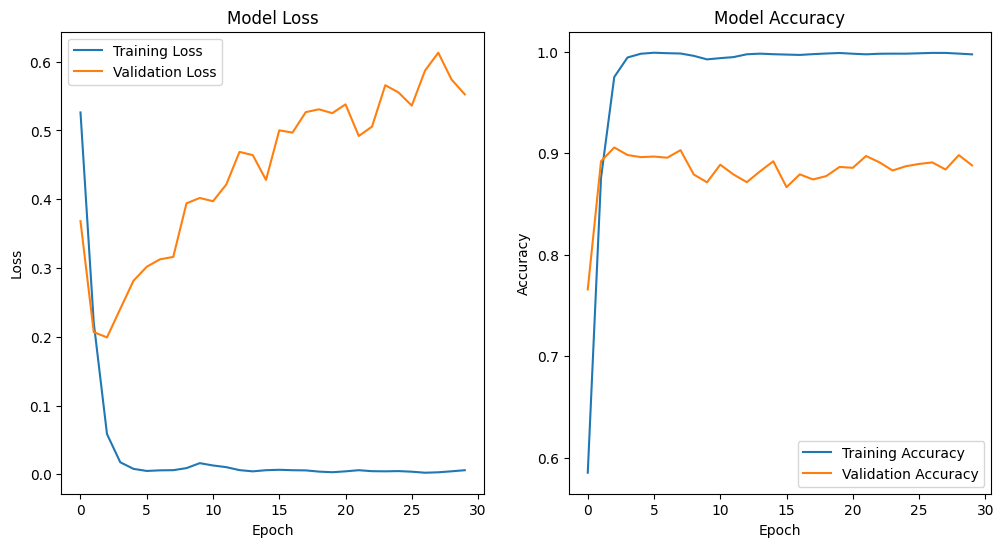

In [27]:
# Plot the training and validation loss at each epoch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy at each epoch
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8876 - loss: 0.5681
Loss: 0.5524438619613647
Accuracy: 0.8879081010818481


In [29]:
# Predict the labels for the test set
y_pred_cat = model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Display the total number of parameters
model.summary()

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                 precision    recall  f1-score   support

 Mixed Feelings       0.87      0.93      0.90      2354
Not Recommended       0.89      0.94      0.92      2398
    Recommended       0.91      0.79      0.84      2385

       accuracy                           0.89      7137
      macro avg       0.89      0.89      0.89      7137
   weighted avg       0.89      0.89      0.89      7137



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       4,105,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 98, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,489,611 (47.64 MB)

 Trainable params: 4,163,203 (15.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,326,408 (31.76 MB)